# Bayesian Beta

http://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

import os
import quandl

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 10)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# put your Quandl API KEY in your .profile as
# export QUANDL_API_KEY="ABC_abc123..." 
QUANDL_API_KEY = os.environ['QUANDL_API_KEY']
quandl.ApiConfig.api_key = QUANDL_API_KEY

In [4]:
from pandas_datareader import data
from datetime import datetime

In [5]:
import pandas_datareader as pdr

In [6]:
print pdr.__version__

0.6.0


In [7]:
start_date = "2015-12-31"
end_date = "2017-12-31"

In [8]:
spy = data.DataReader('SPY', 'google', start_date, end_date)

In [9]:
stock = data.DataReader('SSO', 'google', start_date, end_date)

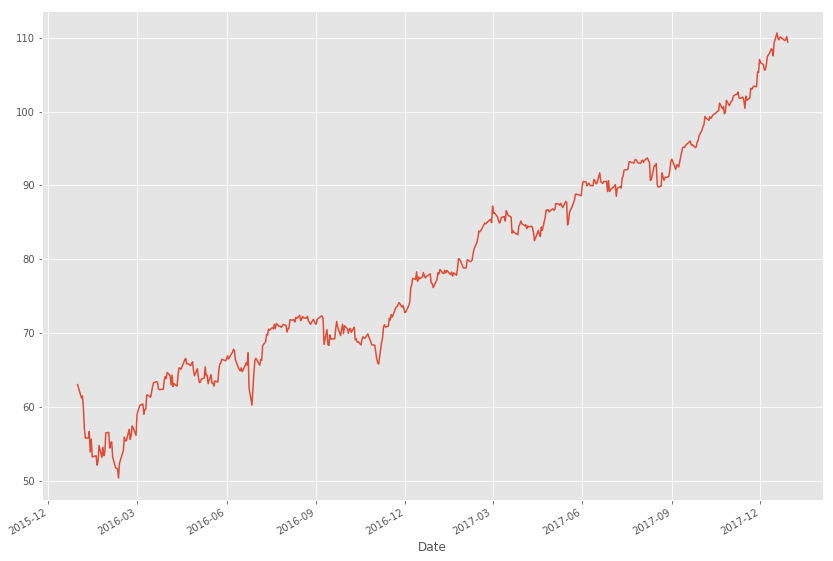

In [10]:
#stock = quandl.get("WIKI/WTW", start_date=start_date, end_date=end_date)
#stock['Adj. Close'].plot()
stock['Close'].plot()

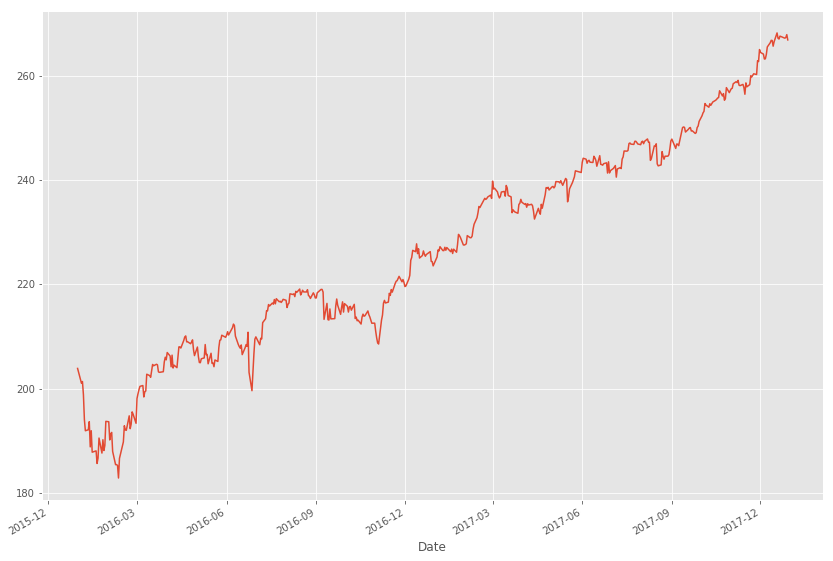

In [11]:
spy['Close'].plot()

In [12]:
#df = pd.concat([spy['Close'], stock['Adj. Close']], axis=1)
df = pd.concat([spy['Close'], stock['Close']], axis=1)

df.columns = ['spy', 'stock']

In [13]:
returns = df.pct_change()
returns = returns.fillna(0.0);

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
X, y = returns.spy, returns.stock
lr = LinearRegression()
lr.fit(X.values.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

[1.95198852]
9.452699785865762e-05


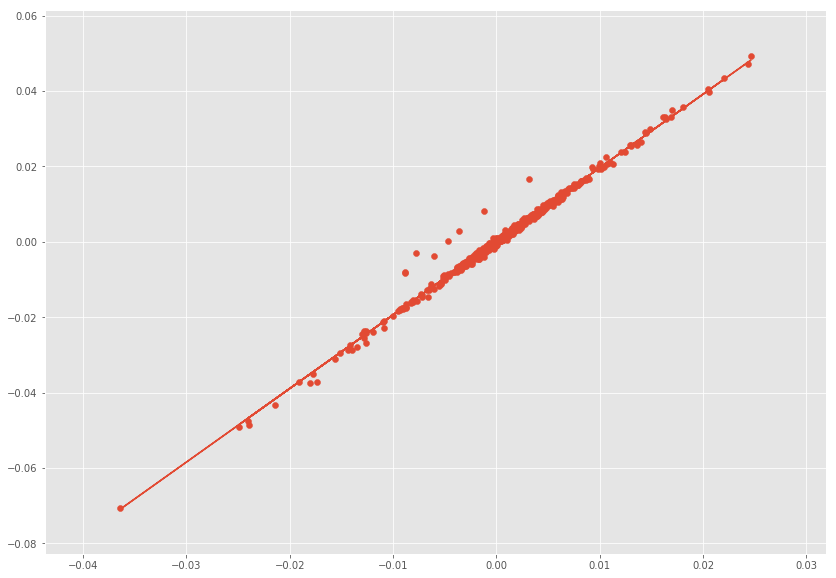

In [16]:
plt.scatter(returns.spy, returns.stock);
plt.plot(X, lr.intercept_ + lr.coef_ * X)
print lr.coef_
print lr.intercept_

In [17]:
import pymc3 as pm

In [18]:
with pm.Model() as model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('intercept', 0, sd=20)
    x_coeff = pm.Normal('beta', 0, sd=20)

    # Define the linear model
    stock = intercept + x_coeff * X
    
    ## define prior for Student T degrees of freedom
    nu = pm.Uniform('nu', lower=1, upper=10)
    
    likelihood = pm.StudentT(
        'y',
        mu=stock,
        sd=sigma,
        nu=nu,
        observed=y
    )

    # Inference!
    trace = pm.sample(5000) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_interval__, beta, intercept, sigma_log__]
100%|██████████| 5500/5500 [00:24<00:00, 223.12it/s]
The acceptance probability does not match the target. It is 0.9568355197035052, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9540859552792411, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9589607465575682, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9260775633529115, but should be close to 0.8. Try to increase the number of tuning steps.


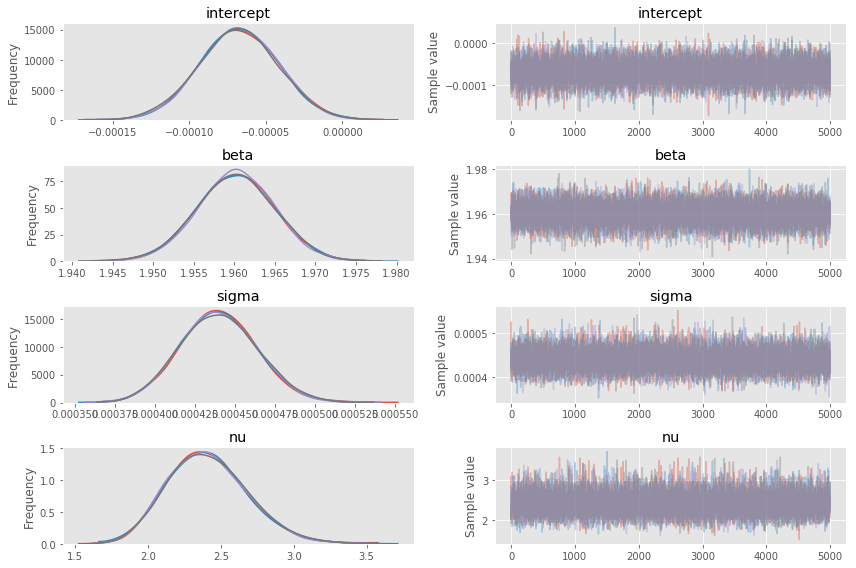

In [19]:
pm.traceplot(trace);

In [20]:
map_estimate = pm.find_MAP(model=model)
map_estimate

logp = 2,915.8, ||grad|| = 607.78: 100%|██████████| 48/48 [00:00<00:00, 444.06it/s]      


{'beta': array(1.96348931),
 'intercept': array(-6.33852395e-05),
 'nu': array(5.63823396),
 'nu_interval__': array(0.06145665),
 'sigma': array(0.00052693),
 'sigma_log__': array(-7.54843983)}

In [21]:
1.96*0.666 + .33

1.6353600000000001